In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Set device variable

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

# Prepare Dataset objects

In [3]:
data_path = './'

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

n_out = 10

# Prepare Dataloader objects

In [4]:
#kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available()else {}

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64, shuffle=True)#,  **kwargs)

val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,shuffle=False)#, **kwargs)

# Build a Very Deep Neural Network 

Thinking about a convolutional neural network with more than 100 layers. How can we build that network in PyTorch without losing our minds in the process? 

**The standard strategy is to define a building block, such as a (Conv2d, ReLU, Conv2d) + skip connection block, and then build the network dynamically in a for loop.**

The following shows a deep architecture with residual connections. On the left, we define a simplistic residual block. On the right, we use it as a building block in building a very deep network.

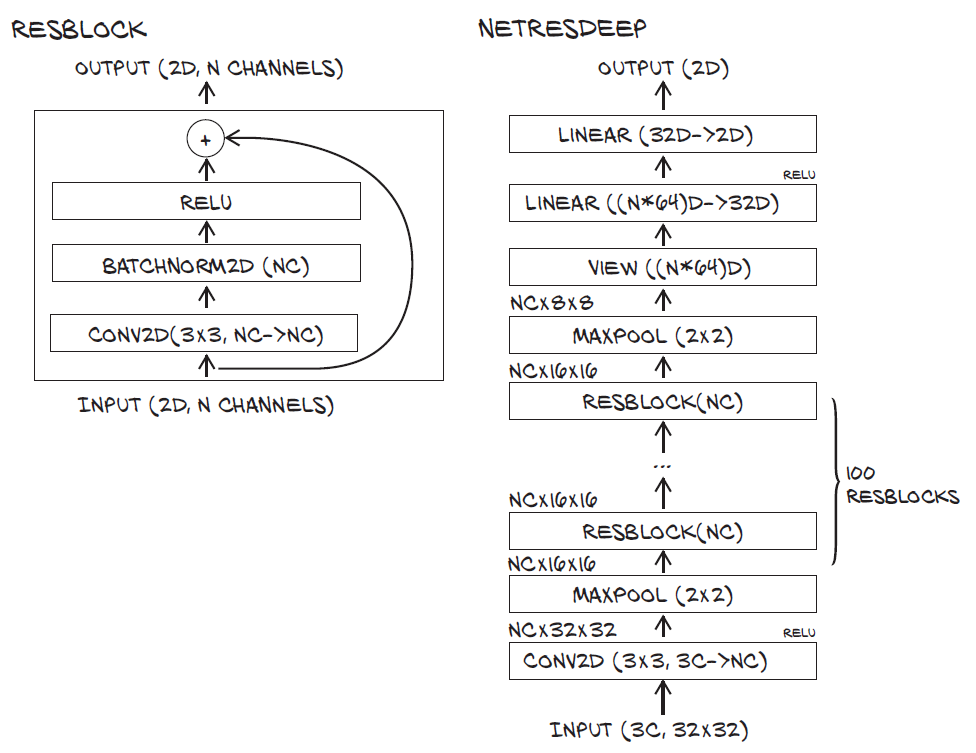

In [5]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [6]:
import torch.nn.functional as F

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, n_out)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = NetResDeep(n_chans1=16, n_blocks=100)

# model.to(device)

# Start Training

In [ ]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    model.train(True)
    for imgs, labels in train_loader:
        #imgs, labels = imgs.to(device), labels.to(device)
        
        outputs = model(imgs)   # important:  nn.Conv2d expects a B × C × H × W shaped tensor as input
        train_loss = loss_fn(outputs, labels)
  
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            #imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            val_loss = loss_fn(outputs, labels)
            
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    print("Epoch: %d, train_loss: %f, val_loss: %f, val_accuracy: %f" % (epoch, float(train_loss), float(val_loss), (correct / total)))

Epoch: 0, train_loss: 1.521208, val_loss: 1.504767, val_accuracy: 0.398400
Epoch: 1, train_loss: 1.152455, val_loss: 1.577382, val_accuracy: 0.452900
Epoch: 2, train_loss: 1.502360, val_loss: 1.663084, val_accuracy: 0.466700
Epoch: 3, train_loss: 1.318826, val_loss: 1.181726, val_accuracy: 0.549500
Epoch: 4, train_loss: 0.857675, val_loss: 0.894784, val_accuracy: 0.557600
